In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

from sklearn.model_selection import StratifiedKFold
from data_generation import m_0, g_0, get_data
from dml_algorithm import mm_ate, dml_ate

In [2]:
with open('opt_params_xgboost.pkl', 'rb') as pickle_file:
    xgb_params_dict_dict = pickle.load(pickle_file)

In [3]:
rmse = np.empty((7, 3)) 
K=5

for i, (N, xgb_params_dict) in enumerate(xgb_params_dict_dict.items()):
    model_g0, model_g1 = xgb.XGBRegressor(objective='reg:squarederror'), xgb.XGBRegressor(objective='reg:squarederror')
    model_g0.set_params(**xgb_params_dict['g0'])
    model_g1.set_params(**xgb_params_dict['g1'])
    model_g = [model_g0, model_g1]
    model_m = xgb.XGBClassifier(objective='binary:logistic')
    model_m.set_params(**xgb_params_dict['m'])
    y_data, d_data, x_data = get_data(N)

    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    g0_rmse, g1_rmse, m_rmse = [], [], []
    g_rmse = [g0_rmse, g1_rmse]
    for (train_indices, eval_indices) in skf.split(X=x_data, y=d_data):
        y_train, d_train, x_train = y_data[train_indices], d_data[train_indices], x_data[train_indices]
        y_eval, d_eval, x_eval = y_data[eval_indices], d_data[eval_indices], x_data[eval_indices]

        # Estimate outcome regression functions g_0(d)
        for d in [0, 1]:
            model_g[d].fit(X=x_train[d_train==d], y=y_train[d_train==d])
            rmse_ = np.sqrt(np.mean((model_g[d].predict(x_eval)-g_0(d,x_eval))**2))
            g_rmse[d].append(rmse_)

        # Estimate propensity score m_0
        model_m.fit(X=x_train, y=d_train)
        rmse_ = np.sqrt(np.mean((model_m.predict_proba(x_eval)[:,1]-m_0(x_eval))**2))
        m_rmse.append(rmse_)

    rmse[i, 0] = np.mean(g_rmse[0])
    rmse[i, 1] = np.mean(g_rmse[1])
    rmse[i, 2] = np.mean(m_rmse)

In [4]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
names = ['g_0', 'g_1', 'm']

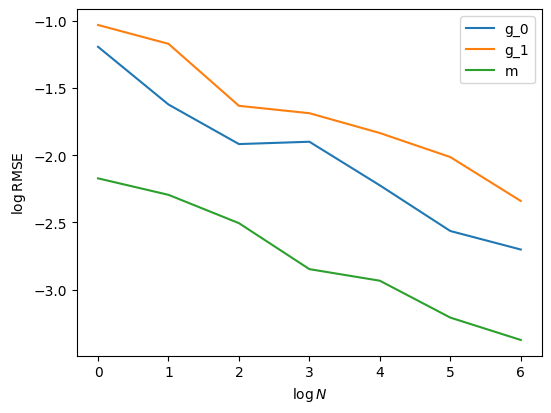

In [5]:
plt.figure(figsize=(6, 4.5))
for k in range(3):
    plt.plot(range(7), np.log(rmse[:,k]), color=colors[k], label=names[k])
plt.xlabel(r'$\log N$')
plt.ylabel(r'$\log$' + 'RMSE')
plt.legend()

In [6]:
sample_sizes = list(xgb_params_dict_dict.keys())
slopes = np.polyfit(np.log(sample_sizes), np.log(rmse), 1)[0,:]
-slopes

array([0.34604777, 0.29973723, 0.302132  ])